## Evaluating FAIRness of CSDMS models

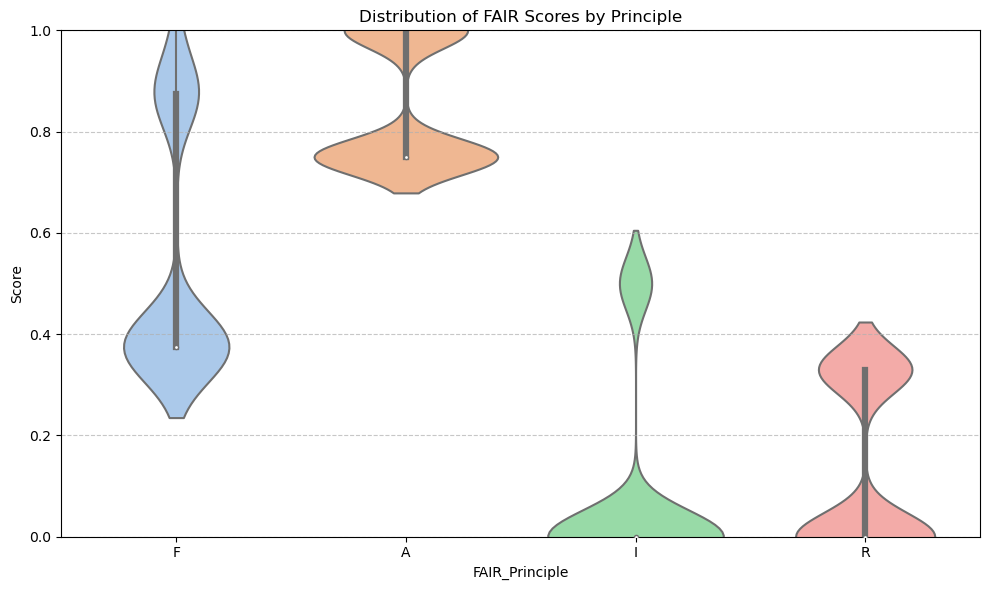

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the directory containing output JSON files
output_dir = Path("out")

# Collect FAIR scores
records = []

for file in output_dir.glob("*.json"):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            if not isinstance(data, dict) or not data:
                print(f"kipping empty or malformed JSON in {file.name}")
                continue
            model_name = list(data.keys())[0]
            model_data = data[model_name]
            scores = model_data.get("scores", {})
            if not scores:
                print(f"No 'scores' found in {file.name}")
                continue
            records.append({
                "model": model_name,
                "F": scores.get("F"),
                "F1": scores.get("F1"),
                "F2": scores.get("F2"),
                "F3": scores.get("F3"),
                "F4": scores.get("F4"),
                "A": scores.get("A"),
                "A1": scores.get("A1"),
                "A2": scores.get("A2"),
                "I": scores.get("I"),
                "I1": scores.get("I"),
                "I2": scores.get("I2"),
                "R": scores.get("R"),
                "R1": scores.get("R1"),
                "R2": scores.get("R2"),
                "R3": scores.get("R3")
            })
    except Exception as e:
        print(f"Error reading {file.name}: {e}")

# Guard against empty data
if not records:
    raise ValueError("No valid FAIR score records were found in the directory.")

# Convert to DataFrame
df = pd.DataFrame(records)

# Reshape DataFrame to long format for seaborn
df_melted = df.melt(id_vars="model", value_vars=["F", "A", "I", "R"],
                    var_name="FAIR_Principle", value_name="Score")

# Plotting
plt.figure(figsize=(10, 6))
sns.violinplot(x="FAIR Principles", y="Score", data=df_melted, inner="box", palette="pastel")

plt.title("Distribution of FAIR Scores by Principle")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Evaluating FAIRness of CSDMS models across domains

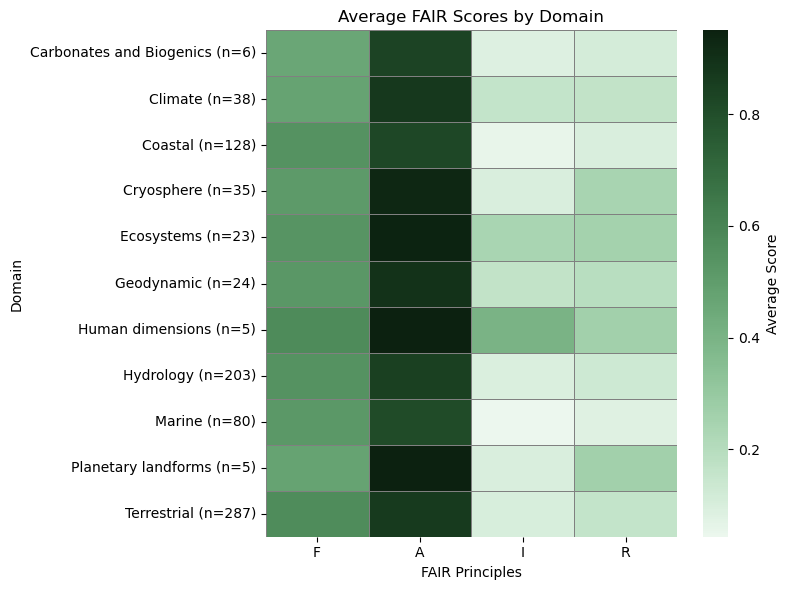

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import json
from pathlib import Path

# Path to directory with codemeta files
codemeta_dir = Path('../../schemas/csdms/codemeta')

# Collect model keywords from JSON files
keywords = []

for file in codemeta_dir.glob("*.json"):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            if not isinstance(data, dict) or not data:
                print(f"Skipping empty or malformed JSON in {file.name}")
                continue
            keywords.append({
                "model": data.get("name"),
                "keywords": data.get("keywords")
            })
    except Exception as e:
        print(f"Error reading {file.name}: {e}")

# Convert keyword records to DataFrame
df_kw = pd.DataFrame(keywords)

# Merge with FAIR scores (assumes df already loaded or defined)
df_res = df.merge(df_kw, how='left', on='model')

# Parse 'keywords' column into actual Python lists
def safe_eval(val):
    if isinstance(val, float) and pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except Exception:
        return []

df_res['keywords'] = df_res['keywords'].apply(safe_eval)

# Define target domains to group by
domains = [
    'Carbonates and Biogenics',
    'Climate',
    'Coastal',
    'Cryosphere',
    'Ecosystems',
    'Geodynamic',
    'Human dimensions',
    'Hydrology',
    'Marine',
    'Planetary landforms',
    'Terrestrial'
]

# Aggregate FAIR scores by domain
domain_data = []
for domain in domains:
    filtered_df = df_res[df_res['keywords'].apply(lambda x: domain in x)]
    if not filtered_df.empty:
        avg_scores = filtered_df[['F', 'A', 'I', 'R']].mean()
        domain_data.append({
            'Domain': f"{domain} (n={len(filtered_df)})",
            'F': avg_scores['F'],
            'A': avg_scores['A'],
            'I': avg_scores['I'],
            'R': avg_scores['R']
        })

# Prepare data for heatmap
agg_df = pd.DataFrame(domain_data)
agg_df.set_index('Domain', inplace=True)

# Drop rows with missing scores to avoid annotation errors
agg_df = agg_df.dropna(subset=['F', 'A', 'I', 'R'])

# Create custom colormap
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, as_cmap=True)

# Create the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    agg_df, annot=False, cmap=cmap,
    cbar_kws={'label': 'Average Score'},
    linewidths=0.5, linecolor='gray'
)

plt.title("Average FAIR Scores by Domain")
plt.xlabel("FAIR Principles")
plt.ylabel("Domain")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Comparison of FAIRness of CSDMS models in one domain

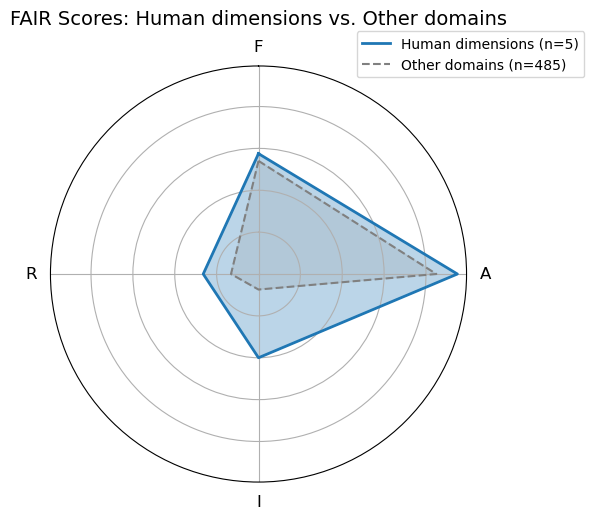

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the domain to highlight
domain_name = "Human dimensions"
top_level_indicators = ['F', 'A', 'I', 'R']

# Ensure 'keywords' column is evaluated
df_res['keywords'] = df_res['keywords'].apply(safe_eval)

# Filter models that include the domain
in_domain = df_res[df_res['keywords'].apply(lambda x: domain_name in x)]
out_domain = df_res[~df_res['keywords'].apply(lambda x: domain_name in x)]

# Count models
n_in = len(in_domain)
n_out = len(out_domain)

# Average FAIR scores
domain_scores = in_domain[top_level_indicators].mean()
other_scores = out_domain[top_level_indicators].mean()

# Convert to lists for radar plot
domain_values = domain_scores.tolist()
other_values = other_scores.tolist()

# Prepare radar chart values
angles = np.linspace(0, 2 * np.pi, len(top_level_indicators), endpoint=False).tolist()
domain_values += domain_values[:1]
other_values += other_values[:1]
angles += angles[:1]

# Create radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_level_indicators, fontsize=12)

# Plot domain
ax.plot(angles, domain_values, color='tab:blue', linewidth=2, label=f"{domain_name} (n={n_in})")
ax.fill(angles, domain_values, color='tab:blue', alpha=0.3)

# Plot others
ax.plot(angles, other_values, color='gray', linewidth=1.5, linestyle='--', label=f"Other domains (n={n_out})")
ax.fill(angles, other_values, color='gray', alpha=0.15)

# Style
ax.set_yticklabels([])  # remove radial labels
ax.set_title(f"FAIR Scores: {domain_name} vs. Other domains", fontsize=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

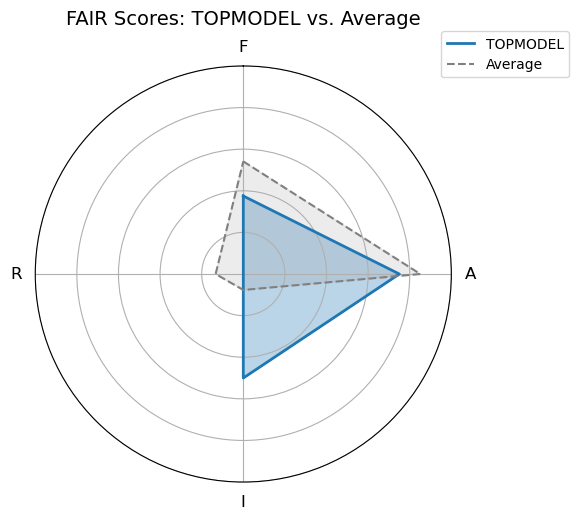

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# # Load your dataset
# df = pd.read_csv("output_2.csv")  # replace with your actual path

# Choose the model to compare
model_name = "TOPMODEL"  # change this to the model you want
top_level_indicators = ['F', 'A', 'I', 'R']

# Extract model and average scores
model_top = df[df['model'] == model_name][top_level_indicators].iloc[0]
avg_top = df[df['model'] != model_name][top_level_indicators].mean()

model_values = model_top.tolist()
avg_values = avg_top.tolist()

# Prepare radar chart values
angles = np.linspace(0, 2 * np.pi, len(top_level_indicators), endpoint=False).tolist()
model_values += model_values[:1]  # close the loop
avg_values += avg_values[:1]
angles += angles[:1]

# Create radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_level_indicators, fontsize=12)

# Plot model
ax.plot(angles, model_values, color='tab:blue', linewidth=2, label=model_name)
ax.fill(angles, model_values, color='tab:blue', alpha=0.3)

# Plot average
ax.plot(angles, avg_values, color='gray', linewidth=1.5, linestyle='--', label='Average of CSDMS models')
ax.fill(angles, avg_values, color='gray', alpha=0.15)

# Style
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([])  # remove radial labels
ax.set_title(f"FAIR Scores: {model_name} vs. Average", fontsize=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()